Created on September 29 2020

@author: Param Shah

In [ ]:
import tensorflow as tf
import os
import time
from matplotlib import pyplot as plt
from IPython import display
from glob import glob
from keras.layers.convolutional import UpSampling2D, Conv2D

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls '/content/drive/My Drive/archive.zip'

'/content/drive/My Drive/archive.zip'


In [ ]:
!unzip '/content/drive/My Drive/archive.zip'

In [ ]:
PATH = os.listdir("cityscapes_data/cityscapes_data")

PATH

['train', 'val']

In [ ]:
BUFFER_SIZE = 400
batch_size = 16
img_W = 256
img_H = 256

In [ ]:
def preprocess(image):
  imag = tf.io.read_file(image)
  image = tf.image.decode_jpeg(imag)

  w = tf.shape(image)[1]

  #splitting the input image and the real image into 2 new images
  w = w // 2
  ground_img = image[:, :w, :]
  input_img = image[:, w:, :]

  input_img = tf.cast(input_img, tf.float32)
  ground_img = tf.cast(ground_img, tf.float32)

   #resize the image
  input_img = tf.image.resize(input_img, [256, 256],method=tf.image.ResizeMethod.NEAREST_NEIGHBOR) #Input image

  ground_img = tf.image.resize(ground_img, [256, 256],method=tf.image.ResizeMethod.NEAREST_NEIGHBOR) #Ground Truth image

  return input_img, ground_img

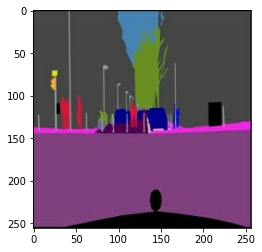

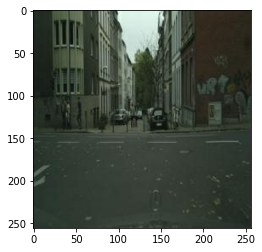

In [ ]:
inp, re = preprocess("cityscapes_data/cityscapes_data/train/10.jpg")
# casting to int for matplotlib to show the image
plt.figure()
plt.imshow(inp/255.0)
plt.figure()
plt.imshow(re/255.0)

In [ ]:
# normalizing the images to [-1, 1]
def normalize(input_image, real_image):
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1

  return input_image, real_image

As you can see in the images below that they are going through random jittering Random jittering as described in the paper is to

1)Resize an image to bigger height and width

2)Randomly crop to the target size

3)Randomly flip the image horizontally

this is a trick to avoid overfitting

In [ ]:

def random_jitter(input_img, ground_img,img_W,img_H):

  # randomly cropping to 256 x 256 x 3
  stacked_image = tf.stack([input_img, ground_img], axis=0)
  cropped_image = tf.image.random_crop(stacked_image, size=[2, img_H, img_W, 3])
  input_img, ground_img = cropped_image[0], cropped_image[1]

# If training => do random flip , this is a trick to avoid overfitting
  if tf.random.uniform(()) > 0.5:
    # random mirroring
    input_img = tf.image.flip_left_right(input_img)
    ground_img = tf.image.flip_left_right(ground_img)

  return input_img, ground_img


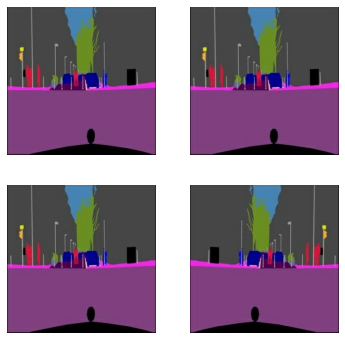

In [ ]:
plt.figure(figsize=(6, 6))
for i in range(4):
  rj_inp, rj_re = random_jitter(inp, re,img_W,img_H)
  plt.subplot(2, 2, i+1)
  plt.imshow(rj_inp/255.0)
  plt.axis('off')
plt.show()

In [ ]:
def train(image):
  input_img, ground_img = preprocess(image)
  input_img, ground_img = random_jitter(input_img, ground_img,img_W,img_H)
  input_img, ground_img = normalize(input_img, ground_img)

  return input_img, ground_img

In [ ]:
def test(image):
  input_img, ground_img = preprocess(image)
  input_img, ground_img = normalize(input_img, ground_img)

  return input_img, ground_img

In [ ]:
#calling the training data
train_dataset = tf.data.Dataset.list_files("cityscapes_data/cityscapes_data/train/*.jpg")
train_dataset = train_dataset.map(train).shuffle(BUFFER_SIZE).batch(batch_size).cache()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [ ]:
#calling the testing data
test_dataset = tf.data.Dataset.list_files("cityscapes_data/cityscapes_data/val/*.jpg")
test_dataset = test_dataset.map(test).batch(batch_size)

In [ ]:
channels =3
gf =64
def conv2d(layer_input, filters, f_size=3, bn=True):
    d = tf.keras.layers.Conv2D(filters, kernel_size=f_size, strides=2,use_bias=False, padding='same')(layer_input)
    d = tf.keras.layers.LeakyReLU()(d)
    if bn:
        d = tf.keras.layers.BatchNormalization()(d)
    return d

          #Layers used during upsampling
def deconv2d(layer_input, skip_input, filters, f_size=3, dropout_rate=False):
    u = tf.keras.layers.Conv2DTranspose(filters, kernel_size=f_size, strides=2,use_bias=False, padding='same')(layer_input)
    if dropout_rate:
        u = tf.keras.layers.Dropout(0.5)(u)
    u = tf.keras.layers.BatchNormalization()(u)
    u = tf.keras.layers.LeakyReLU()(u)
    u = tf.keras.layers.Concatenate()([u, skip_input]) #skip connection
    return u
def Generator():
    initializer = tf.random_normal_initializer(0., 0.02)
    #Layers used during downsampling

    d0 = tf.keras.layers.Input(shape=[256,256,3])

    # Downsampling
    d1 = conv2d(d0, gf, bn=False)
    d2 = conv2d(d1, gf*2)
    d3 = conv2d(d2, gf*4)
    d4 = conv2d(d3, gf*8)
    d5 = conv2d(d4, gf*8)
    d6 = conv2d(d5, gf*8)
    d7 = conv2d(d6, gf*8)
    d8 = conv2d(d7, gf*8)

    # Upsampling
    u1 = deconv2d(d8, d7, gf*8,dropout_rate=True)
    u2 = deconv2d(u1, d6, gf*8,dropout_rate=True)
    u3 = deconv2d(u2, d5, gf*8,dropout_rate=True)
    u4 = deconv2d(u3, d4, gf*8)
    u5 = deconv2d(u4, d3, gf*4)
    u6 = deconv2d(u5, d2, gf*2)
    u7 = deconv2d(u6, d1, gf)

    #d = UpSampling2D(size=2)(d7)
    output_img = tf.keras.layers.Conv2DTranspose(channels, kernel_size=4, strides=2, padding='same', use_bias=False,activation='tanh')(u7)

    return tf.keras.Model(d0, output_img)

In [ ]:
generator = Generator()
#tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

In [ ]:
Lambda = 100
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(disc_generated_output), disc_generated_output)

  # mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (Lambda * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

In [ ]:
df=64
def d_layer(layer_input, filters, f_size=4, bn=True):
    d = tf.keras.layers.Conv2D(filters, kernel_size=f_size, strides=2,use_bias=False, padding='same')(layer_input)
    d = tf.keras.layers.LeakyReLU()(d)
    if bn:
        d = tf.keras.layers.BatchNormalization()(d)
    return d
def Discriminator():
        initializer = tf.random_normal_initializer(0., 0.02)
        img_A = tf.keras.layers.Input(shape=[256, 256, 3])
        img_B = tf.keras.layers.Input(shape=[256, 256, 3])

        combined_imgs = tf.keras.layers.Concatenate(axis=-1)([img_A, img_B])

        d1 = d_layer(combined_imgs, df, bn=False)
        d2 = d_layer(d1, df*2)
        d3 = d_layer(d2, df*4)
        zero_pad1 = tf.keras.layers.ZeroPadding2D()(d3)
        conv = tf.keras.layers.Conv2D(512, 4, strides=1,kernel_initializer=initializer,use_bias=False)(zero_pad1) 

        batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

        leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

        zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)

        validity = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2) 

        return tf.keras.Model([img_A, img_B], validity)

In [ ]:

discriminator = Discriminator()
#tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

In [ ]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam()
discriminator_optimizer = tf.keras.optimizers.Adam()
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)



In [ ]:
def generate_images(model, test_input, tar,epoch):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15,15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.savefig(base_path + '/result_{}.png'.format(epoch))
  plt.show()
  plt.close()

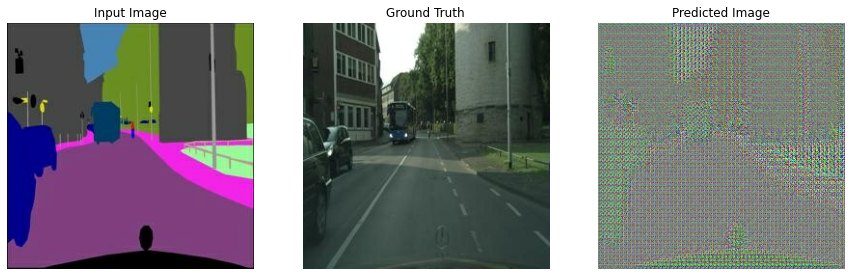

In [ ]:
for example_input, example_target in test_dataset.take(1):
  generate_images(generator, example_input, example_target)

In [ ]:
def train_step(input_image, target, g_loss_metric, d_loss_metric):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  g_loss_metric.update_state(gen_total_loss)
  d_loss_metric.update_state(disc_loss)
  
  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

print("starting training")


starting training


In [ ]:
for i ,(input ,target )in enumerate(test_dataset.take(1)):
  inp =input
  tar =target
  break

Epoch:  0
  loss (g) (d) (g+d):     12.662, 1.058, 13.720


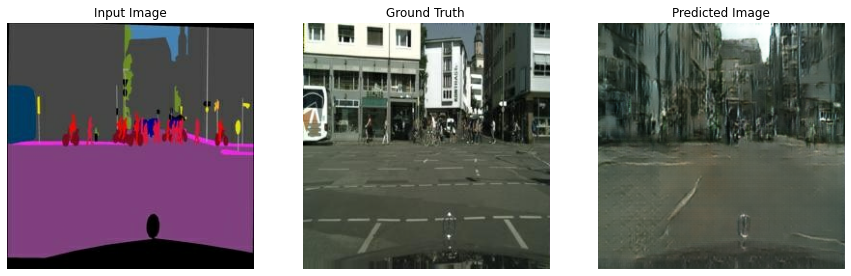

  loss (g_val) (d_val) (g+d_val):     26.175, 0.468, 26.644
Time taken for epoch 0 is 129.59220957756042 sec

Epoch:  1
  loss (g) (d) (g+d):     12.629, 1.070, 13.700
  loss (g_val) (d_val) (g+d_val):     22.614, 0.635, 23.249
Time taken for epoch 1 is 128.471825838089 sec

Epoch:  2
  loss (g) (d) (g+d):     12.571, 1.134, 13.705
  loss (g_val) (d_val) (g+d_val):     24.456, 0.454, 24.910
Time taken for epoch 2 is 128.88501977920532 sec



KeyboardInterrupt: ignored

In [ ]:
epochs=200
g_loss_log = []
d_loss_log = []
g_loss_log_val = []
d_loss_log_val = []
g_loss_metric = tf.keras.metrics.Mean(name='g_train_loss')
d_loss_metric = tf.keras.metrics.Mean(name='d_train_loss')
g_loss_metric_val = tf.keras.metrics.Mean(name='g_train_loss')
d_loss_metric_val = tf.keras.metrics.Mean(name='d_train_loss')
#import pdb;pdb.set_trace()
for epoch in range(epochs):
  start = time.time()
  # Reset the metrics
  g_loss_metric.reset_states()
  d_loss_metric.reset_states()

  for input_image, target in train_dataset:
    train_step(input_image, target, g_loss_metric, d_loss_metric)

  # Get the metric results
  g_mean_loss = g_loss_metric.result()
  d_mean_loss = d_loss_metric.result()
  g_loss_log.append([g_mean_loss])
  d_loss_log.append([d_mean_loss])

  print('Epoch: ', epoch)
  print('  loss (g) (d) (g+d):     {:.3f}, {:.3f}, {:.3f}'.format(g_mean_loss, d_mean_loss, g_mean_loss + d_mean_loss))
  if epoch%5==0:
    generate_images(generator, inp, tar,epoch)
  for input_image, target in test_dataset:
    gen_output_val = generator(input_image, training=True)
    disc_real_output_val = discriminator([input_image, target], training=True)
    disc_generated_output_val = discriminator([input_image, gen_output_val], training=True)

    gen_total_loss_val, gen_gan_loss_val, gen_l1_loss_val = generator_loss(disc_generated_output_val, gen_output_val, target)
    disc_loss_val = discriminator_loss(disc_real_output_val, disc_generated_output_val)

  g_loss_metric_val.update_state(gen_total_loss_val)
  d_loss_metric_val.update_state(disc_loss_val)
    
  g_loss_log_val.append([gen_total_loss_val])
  d_loss_log_val.append([disc_loss_val])
  print('  loss (g_val) (d_val) (g+d_val):     {:.3f}, {:.3f}, {:.3f}'.format(gen_total_loss_val, disc_loss_val, gen_total_loss_val + disc_loss_val))

      
  # saving (checkpoint) the model every 20 epochs
  if (epoch + 1) % 20 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print ('Time taken for epoch {} is {} sec\n'.format(epoch,
                                                      time.time()-start))


In [ ]:
def plot_losses(g_loss, g_loss_val):
    """Plot the losses each epoc during training."""
    #total_loss = [g[0].numpy() + d[0].numpy() for g, d in zip(g_loss, d_loss)]
    g_loss = [g[0].numpy() for g in g_loss]
    #d_loss = [d[0].numpy() for d in d_loss]
    g_loss_val = [g[0].numpy() for g in g_loss_val]
    plt.figure(figsize=(10,5))
    plt.plot(g_loss, label='gen')
    plt.plot(g_loss_val, label='gen_val')
    #plt.plot(total_loss, label='total')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('training loss')
    #plt.savefig('losses.png')
    #plt.close()


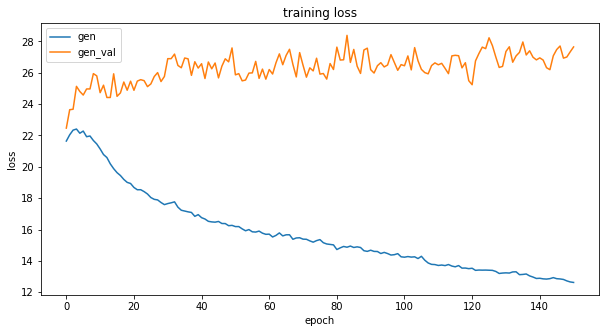

In [ ]:
plot_losses(g_loss_log, g_loss_log_val)

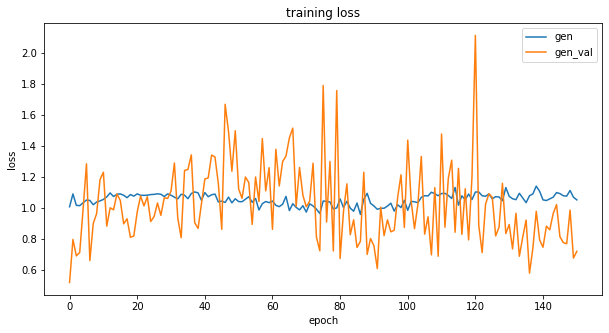

In [ ]:
plot_losses(d_loss_log, d_loss_log_val)

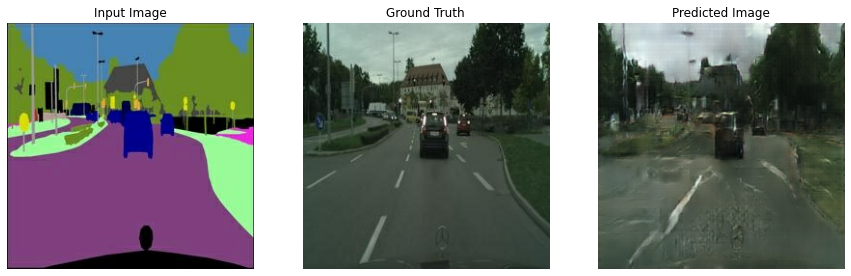

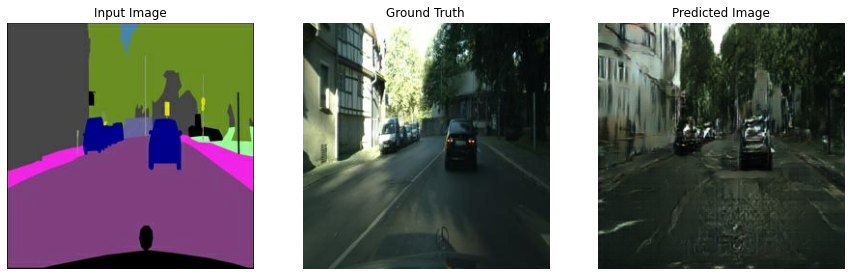

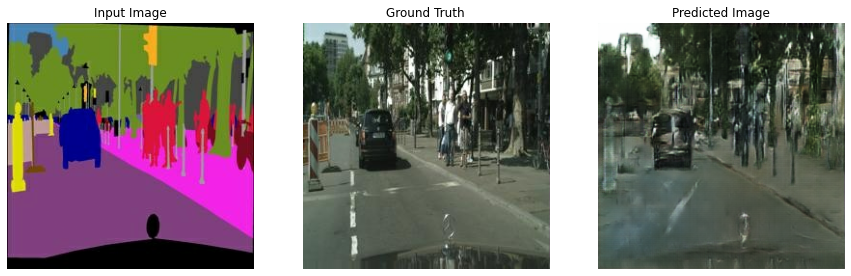

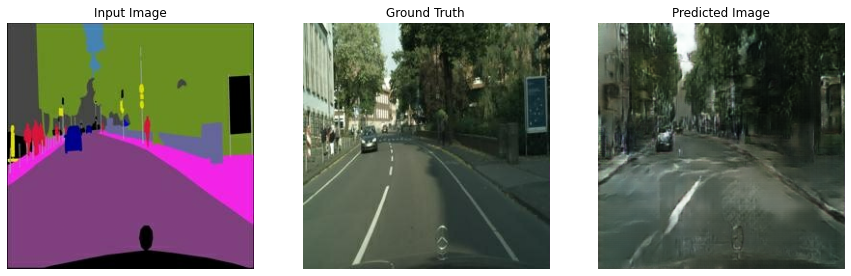

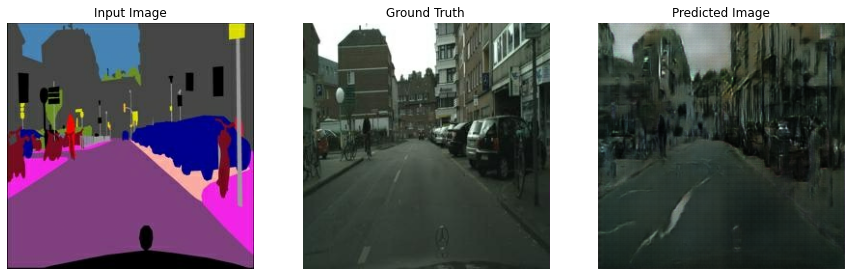

In [ ]:
# Run the trained model on a few examples from the test dataset
for inp, tar in test_dataset.take(5):
  generate_images(generator, inp, tar)

In [ ]:
def generate_images_TRUE(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(5,5))

  display_list = [tar[0]]
  title = ['Ground Truth']
  plt.title(title[0])
  # getting the pixel values between [0, 1] to plot it.
  plt.imshow(display_list[0] * 0.5 + 0.5)
  plt.axis('off')
  plt.show()

In [ ]:
def generate_images_GROUND(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(5,5))

  display_list = [test_input[0]]
  title = ['Input Image']

  plt.title(title[0])
  # getting the pixel values between [0, 1] to plot it.
  plt.imshow(display_list[0] * 0.5 + 0.5)
  plt.axis('off')
  plt.show()

In [ ]:
def generate_images_PREDICT(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(5,5))

  display_list = [prediction[0]]
  title = ['Predicted Image']

  plt.title(title[0])
  # getting the pixel values between [0, 1] to plot it.
  plt.imshow(display_list[0] * 0.5 + 0.5)
  plt.axis('off')
  plt.show()

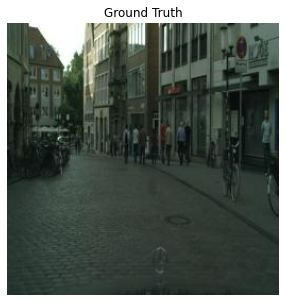

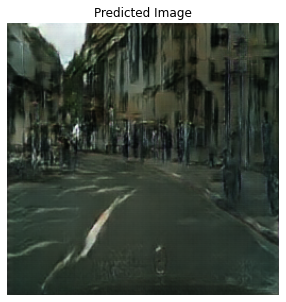

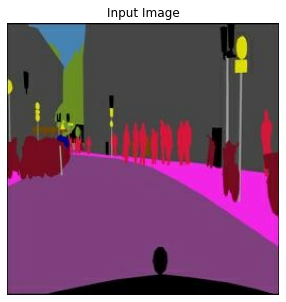

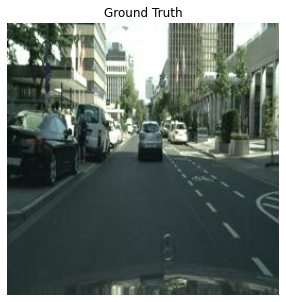

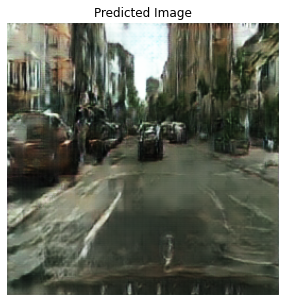

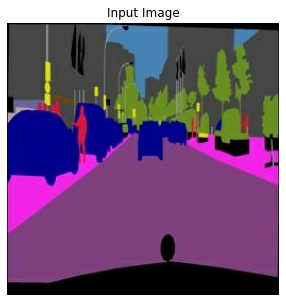

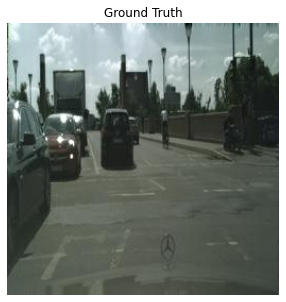

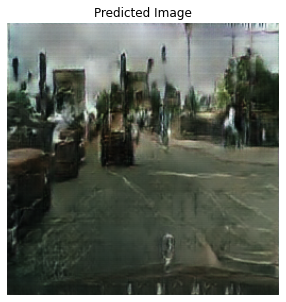

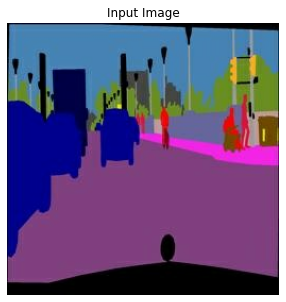

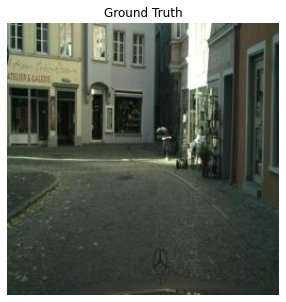

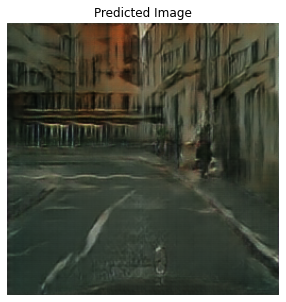

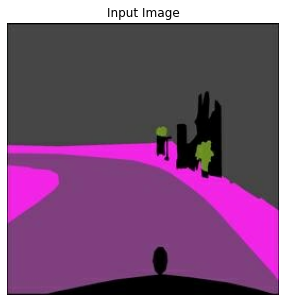

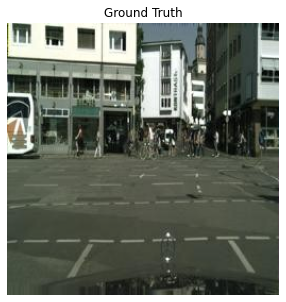

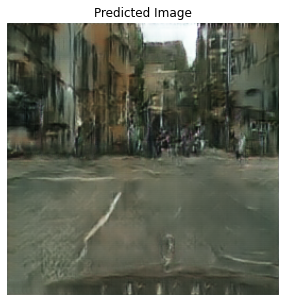

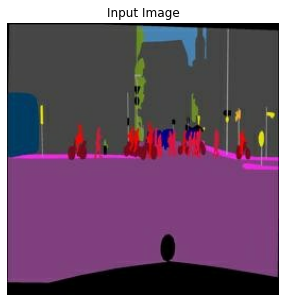

In [ ]:
# Run the trained model on a few examples from the test dataset
for inp, tar in test_dataset.take(5):
  generate_images_TRUE(generator, inp, tar)
  generate_images_PREDICT(generator, inp, tar)
  generate_images_GROUND(generator, inp, tar)